This script obtains the parameters of histogram equalization

In [8]:
import sys
sys.path.append('/workspace/Documents')

import argparse
import os
import sys
import subprocess
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import Diffusion_for_CT_motion.Build_lists.Build_list as Build_list
import Diffusion_for_CT_motion.utils.functions_collection as ff
import Diffusion_for_CT_motion.utils.Data_processing as Data_processing

In [2]:
# find clean images
data_sheet = os.path.join('/mnt/camca_NAS/diffusion_ct_motion/data/Patient_list/Patient_list_train_test_simulated_all_motion_v1.xlsx')
b = Build_list.Build(data_sheet)
_,_,_,_, _,_, x0_list, _, condition_list, _, _,_,_ = b.__build__(batch_list = [0,1,2,3])  # x0 is motino-free, condition is motion-corrupted
n = ff.get_X_numbers_in_interval(total_number = x0_list.shape[0],start_number = 0,end_number = 1, interval = 5)

# randomly pick 30 numbers in n
np.random.seed()
np.random.shuffle(n)
n = n[:30]

x0_list = x0_list[n]; condition_list = condition_list[n]
print(x0_list)

['/mnt/camca_NAS/Portable_CT_data/simulations_202404/simulated_all_motion_v1/00029913/0000455859/static/image_data/recon_resample.nii.gz'
 '/mnt/camca_NAS/Portable_CT_data/simulations_202404/simulated_all_motion_v1/00111245/0000455449/static/image_data/recon_resample.nii.gz'
 '/mnt/camca_NAS/Portable_CT_data/simulations_202404/simulated_all_motion_v1/00214843/0000455437/static/image_data/recon_resample.nii.gz'
 '/mnt/camca_NAS/Portable_CT_data/simulations_202404/simulated_all_motion_v1/00010431/0000019300/static/image_data/recon_resample.nii.gz'
 '/mnt/camca_NAS/Portable_CT_data/simulations_202404/simulated_all_motion_v1/00214815/0000455367/static/image_data/recon_resample.nii.gz'
 '/mnt/camca_NAS/Portable_CT_data/simulations_202404/simulated_all_motion_v1/00104566/0000455266/static/image_data/recon_resample.nii.gz'
 '/mnt/camca_NAS/Portable_CT_data/simulations_202404/simulated_all_motion_v1/00154137/0000455529/static/image_data/recon_resample.nii.gz'
 '/mnt/camca_NAS/Portable_CT_data/

In [4]:
# build the original histogram
transfer_max = 1500
transfer_min = -800
transfer_weight = 0.5
hist = np.zeros(transfer_max - transfer_min + 1, int)
for img in x0_list:
    img_np = nb.load(img).get_fdata()
    hist += np.histogram(img_np, bins=np.arange(transfer_min, transfer_max + 2))[0]

In [ ]:
# equalize the histogram
print('Equalizing histogram...', flush=True)
bins = np.arange(-800, 1500 + 1)
bins_mapped = Data_processing.equalize_histogram(bins, hist, transfer_weight)

Equalizing histogram...


In [5]:
####### save_bins
# np.save('/mnt/camca_NAS/diffusion_ct_motion/data/histogram_equalization/bins.npy', bins)
# np.save('/mnt/camca_NAS/diffusion_ct_motion/data/histogram_equalization/bins_mapped.npy', bins_mapped)

# or load
bins = np.load('/mnt/camca_NAS/diffusion_ct_motion/data/histogram_equalization/bins.npy')
bins_mapped = np.load('/mnt/camca_NAS/diffusion_ct_motion/data/histogram_equalization/bins_mapped.npy')

# example of histogram equalization

Text(0.5, 1.0, 'Transfer function')

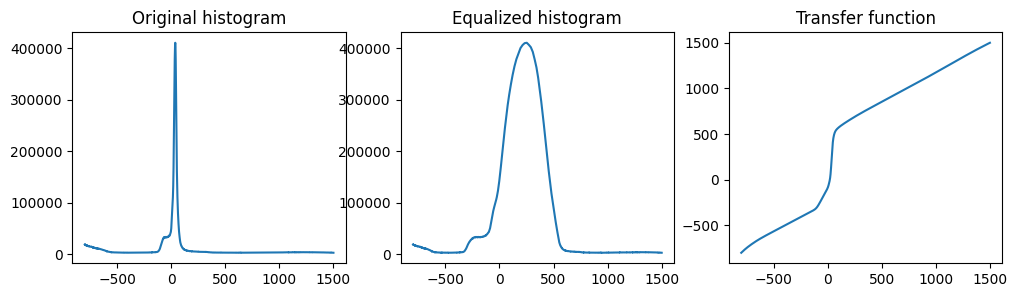

In [6]:
plt.figure(figsize=[12, 3])
plt.subplot(131)
plt.plot(bins, hist)
plt.title('Original histogram')
plt.subplot(132)
plt.plot(bins_mapped, hist)
plt.title('Equalized histogram')
plt.subplot(133)
plt.plot(bins, bins_mapped)
plt.title('Transfer function')

In [9]:
img_test = nb.load(x0_list[0]).get_fdata()
img_test_mapped = Data_processing.apply_transfer_to_img(img_test, bins, bins_mapped)
img_test_normalized = Data_processing.normalize_image(img_test_mapped, normalize_factor = 1000, image_max = None, image_min = -500,invert = False)
img_test_normalized_back = Data_processing.normalize_image(img_test_normalized, normalize_factor = 1000, image_max = None, image_min = -500,invert = True)
img_test_mapped_reverse = Data_processing.apply_transfer_to_img(img_test_normalized_back, bins, bins_mapped, reverse=True)


Reverse error: 1.0018095659319992e-05


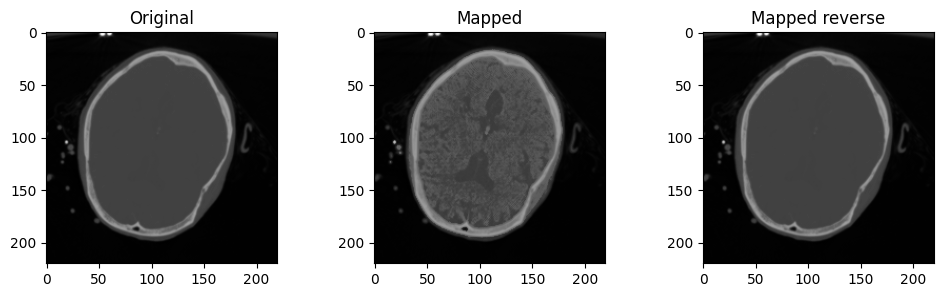

In [10]:
plt.figure(figsize=[12, 3])
plt.subplot(131)
# equal axis
plt.imshow(img_test[:,:,img_test.shape[-1] // 2].T, 'gray')
plt.title('Original')
plt.subplot(132)
plt.imshow(img_test_mapped[:,:,img_test_mapped.shape[-1] // 2].T, 'gray')
plt.title('Mapped')
plt.subplot(133)
plt.imshow(img_test_mapped_reverse[:,:,img_test_mapped_reverse.shape[-1] // 2].T, 'gray')
plt.title('Mapped reverse')

print('Reverse error:', np.mean(np.abs(img_test - img_test_mapped_reverse)), flush=True)